In [10]:
# Import libraries
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings
import miscGeneralMethods
import diversity
from sklearn.decomposition import PCA
from PIL import Image

In [11]:
def setConstants():
    global REPLICATES
    global REPOSITORY
    global FILE_DESCRIPTORS
    global FILE_COMPONENTS_MEDIAN
    global FILE_COVERAGE
    global FILE_PARENTING
    global FILE_STATS
    global EVALUATIONS
    global MAXORGANS
    global VARIABLE_1_PARAMETERS
    global VARIABLE_1_NAME
    global GENERATIONS
    global POPULATION
    
    REPOSITORY='/media/ebb505/ARE-EBB/ARE/are-logs/diversity/'
    FILE_DESCRIPTORS='MD_Cart_WDH.csv'
    FILE_PARENTING='parenting.csv'
    FILE_COMPONENTS_MEDIAN='componentsMedian.csv'
    REPLICATES = 7
    EVALUATIONS = 1000
    MAXORGANS = 16
    GENERATIONS = 10
    POPULATION = 100
    FILE_COVERAGE='coverage.csv'
    FILE_STATS='stats.csv'
#     VARIABLE_1_PARAMETERS = ['trait_100']
    VARIABLE_1_PARAMETERS = ['trait_100','protomatrix_100']
    print('Repository: ' + REPOSITORY)
    print('Descriptors: ' + FILE_DESCRIPTORS)
    print('Components median: ' + FILE_COMPONENTS_MEDIAN)
    print('Replicates: ' + str(REPLICATES))

In [12]:
def getOrgans(data, REPLICATES):
    print('Get organs...')
    INTERVALS =  np.arange(0,1+1/MAXORGANS,1/MAXORGANS)
    listOrgans = []
    for rep in range(REPLICATES):
        tempOrgans = []
        for i in range(4):
            organNumber = []
            for j in INTERVALS:
                organNumber.append(sum(data[rep][0:EVALUATIONS,4+i]==j))
            tempOrgans.append(organNumber)
        listOrgans.append(tempOrgans)
    return listOrgans
def countOrgans(arrayOrgans, REPLICATES):
    print('Count organs...')
    wheelCount = []
    sensorCount = []
    jointCount = []
    casterCount = []
    for rep in range(REPLICATES):
        tempWheel = []
        tempSensor = []
        tempJoint = []
        tempCaster = []
        for i in range(MAXORGANS+1):
            tempWheel.append(arrayOrgans[rep][0][i])
            tempSensor.append(arrayOrgans[rep][1][i])
            tempJoint.append(arrayOrgans[rep][2][i])
            tempCaster.append(arrayOrgans[rep][3][i])
        wheelCount.append(tempWheel)
        sensorCount.append(tempSensor)
        jointCount.append(tempJoint)
        casterCount.append(tempCaster)
    wheelCount = np.array([[int(y) for y in x] for x in wheelCount]) # Convert to array
    sensorCount = np.array([[int(y) for y in x] for x in sensorCount]) # Convert to array
    jointCount = np.array([[int(y) for y in x] for x in jointCount]) # Convert to array
    casterCount = np.array([[int(y) for y in x] for x in casterCount]) # Convert to array
    
    return wheelCount, sensorCount, jointCount, casterCount

def saveOrgans(REPOSITORY, FILE_COMPONENTS_MEDIAN, wheelCount, sensorCount, jointCount, casterCount):
    print("Saving organs file")
    with open(REPOSITORY + FILE_COMPONENTS_MEDIAN, 'w', newline='') as write_obj:
        csv_writer = csv.writer(write_obj)
        for i in range(MAXORGANS+1):
            csv_writer.writerow([np.median(wheelCount[:,i]),np.median(sensorCount[:,i]),np.median(jointCount[:,i]),np.median(casterCount[:,i])])
            
def getViableRobots(REPLICATES, arrayDescriptors):
    print("Getting viable robots...")
    viableRobots = []
    for rep in range(REPLICATES):
        tempWheel = arrayDescriptors[rep][:,4]>0
        tempSensor = arrayDescriptors[rep][:,5]>0
        tempJoint = arrayDescriptors[rep][:,6]>0
        viableRobots.append(arrayDescriptors[rep][(tempWheel|tempJoint)&tempSensor]) # Only robots with sensors AND wheels
    return viableRobots

def plot2DHistogram(REPLICATES, REPOSITORY, data, isViable):
    print("Plotting histogram...")
    fig = plt.figure(facecolor='white')

    INTERVALS =  np.arange(0,10*(1/MAXORGANS),1/MAXORGANS)
    xedges = INTERVALS
    yedges = INTERVALS

    x = []
    y = []
    for rep in range(REPLICATES):
#         x.extend(data[rep][EVALUATIONS-POPULATION:EVALUATIONS,6])
#         y.extend(data[rep][EVALUATIONS-POPULATION:EVALUATIONS,7])
        x.extend(data[rep][:,4])
        y.extend(data[rep][:,5])


    H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))
    H = H.T  # Let each row list bins with common y range.

    for i in range(len(H)):
        for j in range(len(H[i])):

            if(H[i,j] > np.max(H)/5):
                plt.text(j*(1/16)+1/(16*2), i*(1/16)+1/(16*2), str(int(H[i,j])), fontsize=8, horizontalalignment='center').set_color('White')
            else:
                plt.text(j*(1/16)+1/(16*2), i*(1/16)+1/(16*2), str(int(H[i,j])), fontsize=8, horizontalalignment='center').set_color('Black')


    plt.imshow(H, interpolation='nearest', origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='Greys')
    plt.colorbar(label='Robots')
    X, Y = np.meshgrid(xedges, yedges)

    plt.xlabel('Wheels')
    plt.ylabel('Sensors')

    if(isViable):
        plt.title('Viable robots')
    else: 
        plt.title('All robots')
    TICKPOS =  np.arange(1/(MAXORGANS*2),10*(1/MAXORGANS),1/MAXORGANS)
    TICKLABEL = range(0,10,1)
    plt.yticks(TICKPOS, [str(i) for i in TICKLABEL])
    plt.xticks(TICKPOS, [str(i) for i in TICKLABEL])
    if(isViable):
        plt.savefig(REPOSITORY+'wheelsViable.png',dpi=200, bbox_inches='tight')
    else:
        plt.savefig(REPOSITORY+'wheelsAll.png',dpi=200, bbox_inches='tight')
    plt.close(fig)
    
def getCoverage(REPOSITORY,folders,FILE_DESCRIPTORS,FILE_COVERAGE):
    print("Getting coverage...")
    listCoverage = []
    listUniformity = []
    for f in folders:
        descriptors = diversity.load_descriptor(f+'/'+FILE_DESCRIPTORS,diversity.traits_desc_size)
        hist, grid_size = diversity.compute_desc_hist(descriptors,int(8))
        coverage = float(len(hist))/float(grid_size)
        listCoverage.append(coverage)
        uniformity = diversity.uniformity_scores(hist,grid_size)
        listUniformity.append(uniformity)
    with open(REPOSITORY + var1 + FILE_COVERAGE, 'w', newline='') as write_obj:
        csv_writer = csv.writer(write_obj)
        for i in range(len(folders)):
            csv_writer.writerow([listCoverage[i],listUniformity[i],listCoverage[i]/0.00029802322])
    return listCoverage
            
def plotPCA(REPOSITORY,data):
    print("Plotting PCA...")
    newArray = data[0][0]
# #     newArray = np.append(data[0][0],data[1][0],axis=0)
#     newArray = np.append(newArray,data[2][0],axis=0)
    
    pca = PCA(n_components=2)

    principalComponents = pca.fit_transform(newArray[:,2:])
    principalDfNoSym = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

    fig = plt.figure(facecolor='white')

    plt.title('Principal component analysis')
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    plt.xlabel('Principal component 1')
    plt.ylabel('Principal component 2')

#     color1 = np.linspace(0.0, 1.0, num=EVALUATIONS)
    
    color1 = [(1.0, 0.0, 0.0)]*EVALUATIONS
#     color2 = [(0.0, 1.0, 0.0)]*EVALUATIONS
#     color3 = [(0.0, 0.0, 1.0)]*EVALUATIONS
#     colormap = np.append(color1,color2,axis=0)
    
    plt.scatter(principalDfNoSym['principal component 1'][:EVALUATIONS],principalDfNoSym['principal component 2'][:EVALUATIONS],c=color1,label='NN2')
#     plt.scatter(principalDfNoSym['principal component 1'][EVALUATIONS:EVALUATIONS*2],principalDfNoSym['principal component 2'][EVALUATIONS:EVALUATIONS*2],c=color2,label='Proto-Matrix')
#     plt.scatter(principalDfNoSym['principal component 1'][EVALUATIONS*2:EVALUATIONS*3],principalDfNoSym['principal component 2'][EVALUATIONS*2:EVALUATIONS*3],c=color3,label='100')
    plt.legend()
#     clb = plt.colorbar()
#     clb.set_label("Evaluation progression")
#     clb.set_ticks([0.0, 1.0])
#     clb.set_ticklabels(['0', '4000'])


    plt.savefig(REPOSITORY+'/singlePCA.png',dpi=200, bbox_inches='tight')
    plt.close(fig)
    
def plotBar(REPLICATES, REPOSITORY, wheelCount, sensorCount, jointCount, casterCount):
    print("Plotting Bar...")
    temp_list = []
    for i in range(9):
        tempWheelsCount = 0
        tempSensorsCount = 0
        tempJointCount = 0
        tempCasterCount = 0
        for rep in range(REPLICATES):
            tempWheelsCount = tempWheelsCount + wheelCount[rep][i]
            tempSensorsCount = tempSensorsCount + sensorCount[rep][i]
            tempJointCount = tempJointCount + jointCount[rep][i] # Each leg has two joints. We need to substract here
            tempCasterCount = tempCasterCount + casterCount[rep][i] # Each leg has two joints. We need to substract here
        temp_list.append(tempWheelsCount)
        temp_list.append(tempSensorsCount)
        temp_list.append(tempJointCount)
        temp_list.append(tempCasterCount)
    fig = plt.figure(facecolor='white')
    plt.bar(range(9*4),temp_list,color=['r','g','b','k'])
    plt.text(0, POPULATION*REPLICATES*GENERATIONS*0.7, 'Wheels', horizontalalignment='center',rotation='vertical',fontsize=8)
    plt.text(2, POPULATION*REPLICATES*GENERATIONS*0.7, 'Joints', horizontalalignment='center',rotation='vertical',fontsize=8)
    plt.text(1, POPULATION*REPLICATES*GENERATIONS*0.7, 'Sensors', horizontalalignment='center',rotation='vertical',fontsize=8)
    plt.text(3, POPULATION*REPLICATES*GENERATIONS*0.7, 'Casters', horizontalalignment='center',rotation='vertical',fontsize=8)
    TICKPOS =  range(2,36,4)
    TICKLABEL = range(0,9,1)
    plt.xticks(TICKPOS, [str(i) for i in TICKLABEL])
    plt.ylabel('Number of robots')
    plt.xlabel('Number of organs per robot')
    plt.ylim([0,POPULATION*REPLICATES*GENERATIONS])
    plt.savefig(REPOSITORY+'barPlot.png',dpi=200, bbox_inches='tight')
    plt.close(fig)
def plotSpringsProgression(REPLICATES, REPOSITORY, rep_offsprings):
    # Get total number of offsprings
    rep_offsprings = []
    for rep in range(REPLICATES):
        list_robots_checked = []
        for i in range(EVALUATIONS):
            list_robots_checked.append([arrayParenting[rep][i,0],arrayParenting[rep][i,1],0])
        # Get number of offsprings of each robot
        set_offsprings = []
        for i in range(EVALUATIONS):
            single_offsprings = []
            single_offsprings.append(list_robots_checked[i][0]) # First element is parent!
            for j in range(len(list_robots_checked)):
                if(list_robots_checked[i][0] == list_robots_checked[j][1]):
                    single_offsprings.append(list_robots_checked[j][0])
            set_offsprings.append(single_offsprings)
        rep_offsprings.append(set_offsprings)
    total_offsprings = []
    for i in range(EVALUATIONS):
        temp = 0
        for rep in range(REPLICATES):
            temp = temp + len(rep_offsprings[rep][i]) - 1
    #     print(temp)
        total_offsprings.append(temp)
    fig = plt.figure(facecolor='white')
    plt.bar(range(EVALUATIONS),total_offsprings)
    plt.ylabel('Offspring number')
    plt.xlabel('Evaluation progression')    
    plt.savefig(REPOSITORY+'offspring.png',dpi=200, bbox_inches='tight')
    plt.close(fig)
def getOffsprings(REPLICATES, REPOSITORY, arrayParenting):
    # Get total number of offsprings
    rep_offsprings = []
    for rep in range(REPLICATES):
        list_robots_checked = []
        for i in range(EVALUATIONS):
            list_robots_checked.append([arrayParenting[rep][i,0],arrayParenting[rep][i,1],0])
        # Get number of offsprings of each robot
        set_offsprings = []
        for i in range(EVALUATIONS):
            single_offsprings = []
            single_offsprings.append(list_robots_checked[i][0]) # First element is parent!
            for j in range(len(list_robots_checked)):
                if(list_robots_checked[i][0] == list_robots_checked[j][1]):
                    single_offsprings.append(list_robots_checked[j][0])
            set_offsprings.append(single_offsprings)
        rep_offsprings.append(set_offsprings)
    return rep_offsprings

In [13]:
setConstants()
font = {'weight' : 'normal',
                    'size'   : 14.0}
expDescriptors = []
expCoverage = []
exp_rep_offsprings = []
for var1 in VARIABLE_1_PARAMETERS:
    print('---',var1,'---')
    print(REPOSITORY + var1)
    folders,folderNames = miscGeneralMethods.getDirectories(REPOSITORY + var1)
    
    dataDescriptors = miscGeneralMethods.getDataFromFiles(folders, FILE_DESCRIPTORS, 1)
    arrayDescriptors = miscGeneralMethods.transformDataToArray(dataDescriptors, REPLICATES)

    dataParenting = miscGeneralMethods.getDataFromFiles(folders, FILE_PARENTING, 0)
    arrayParenting = miscGeneralMethods.transformDataToArray(dataParenting, REPLICATES)
    rep_offsprings = getOffsprings(REPLICATES, REPOSITORY, arrayParenting)
    exp_rep_offsprings.append(rep_offsprings)
    plotSpringsProgression(REPLICATES, REPOSITORY + var1, rep_offsprings)
    
    listOrgans = getOrgans(arrayDescriptors, REPLICATES)
    arrayOrgans = miscGeneralMethods.transformDataToArray(listOrgans, REPLICATES)
    wheelCount, sensorCount, jointCount, casterCount = countOrgans(arrayOrgans, REPLICATES)
    saveOrgans(REPOSITORY + var1, FILE_COMPONENTS_MEDIAN, wheelCount, sensorCount, jointCount, casterCount)
    plotBar(REPLICATES, REPOSITORY + var1, wheelCount, sensorCount, jointCount, casterCount)

    viableRobots = getViableRobots(REPLICATES, arrayDescriptors)
    
    plt.rc('font', **font)
    plot2DHistogram(REPLICATES, REPOSITORY + var1, arrayDescriptors, 0)
    plot2DHistogram(REPLICATES, REPOSITORY + var1, viableRobots, 1)
    
    expCoverage.append(getCoverage(REPOSITORY,folders,FILE_DESCRIPTORS,FILE_COVERAGE))
    
    expDescriptors.append(arrayDescriptors)
plotPCA(REPOSITORY,expDescriptors)

Repository: /media/ebb505/ARE-EBB/ARE/are-logs/diversity/
Descriptors: MD_Cart_WDH.csv
Components median: componentsMedian.csv
Replicates: 7
--- trait_100 ---
/media/ebb505/ARE-EBB/ARE/are-logs/diversity/trait_100
Getting directories...
--- Folders:  7
Getting data from files...
Transform data to array...
Getting data from files...
Transform data to array...
Get organs...
Transform data to array...
Count organs...
Saving organs file
Plotting Bar...
Getting viable robots...
Plotting histogram...
Plotting histogram...
Getting coverage...
--- protomatrix_100 ---
/media/ebb505/ARE-EBB/ARE/are-logs/diversity/protomatrix_100
Getting directories...
--- Folders:  8
Getting data from files...
Transform data to array...
Getting data from files...
Transform data to array...
Get organs...
Transform data to array...
Count organs...
Saving organs file
Plotting Bar...
Getting viable robots...
Plotting histogram...
Plotting histogram...
Getting coverage...
Plotting PCA...


Plotting PCA...
8000


ValueError: 'c' argument has 7000 elements, which is inconsistent with 'x' and 'y' with size 1000.

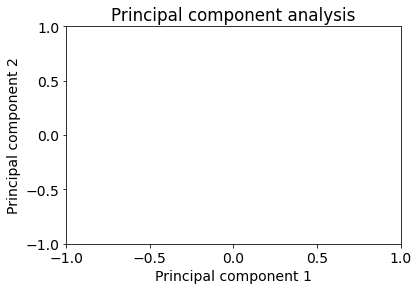

In [16]:
print("Plotting PCA...")
newArray = expDescriptors[0][0][:EVALUATIONS]
# for rep in range(REPLICATES-1):
#     newArray = np.append(newArray,expDescriptors[0][rep][:EVALUATIONS],axis=0)
for rep in range(REPLICATES):
    newArray = np.append(newArray,expDescriptors[1][rep][:EVALUATIONS],axis=0)
print(len(newArray))
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(newArray[:,2:])
principalDfNoSym = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

fig = plt.figure(facecolor='white')

plt.title('Principal component analysis')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

# #     color1 = np.linspace(0.0, 1.0, num=EVALUATIONS)

color1 = [(1.0, 0.0, 0.0)]*EVALUATIONS*REPLICATES
color2 = [(0.0, 1.0, 0.0)]*EVALUATIONS*REPLICATES
# #     color3 = [(0.0, 0.0, 1.0)]*EVALUATIONS
# #     colormap = np.append(color1,color2,axis=0)

# plt.scatter(principalDfNoSym['principal component 1'][:EVALUATIONS*REPLICATES],principalDfNoSym['principal component 2'][:EVALUATIONS*REPLICATES],c=color1,label='NN2')
plt.scatter(principalDfNoSym['principal component 1'][EVALUATIONS*REPLICATES:EVALUATIONS*REPLICATES*2],principalDfNoSym['principal component 2'][EVALUATIONS*REPLICATES:EVALUATIONS*REPLICATES*2],c=color2,label='Proto-Matrix')
# #     plt.scatter(principalDfNoSym['principal component 1'][EVALUATIONS:EVALUATIONS*2],principalDfNoSym['principal component 2'][EVALUATIONS:EVALUATIONS*2],c=color2,label='Proto-Matrix')
# #     plt.scatter(principalDfNoSym['principal component 1'][EVALUATIONS*2:EVALUATIONS*3],principalDfNoSym['principal component 2'][EVALUATIONS*2:EVALUATIONS*3],c=color3,label='100')
plt.legend()
# #     clb = plt.colorbar()
# #     clb.set_label("Evaluation progression")
# #     clb.set_ticks([0.0, 1.0])
# #     clb.set_ticklabels(['0', '4000'])

# #     plt.tricontourf(principalDfNoSym['principal component 1'][EVALUATIONS:EVALUATIONS*2],principalDfNoSym['principal component 2'][EVALUATIONS:EVALUATIONS*2])

plt.savefig(REPOSITORY+'/PCAALLProto.png',dpi=200, bbox_inches='tight')
# # plt.close(fig)

In [18]:
# Get folder ID
folderID = -1
for i in range(len(folders)):
    if(folders[i] == REPOSITORY + var1 + '/bodyplantesting_protomatrix_20_4_12-12-7-7004-2358444281'):
        print(REPOSITORY + var1 + '/bodyplantesting_protomatrix_20_4_12-12-7-7004-2358444281')
        print(i)
        folderID = i 

/media/ebb505/ARE-EBB/ARE/are-logs/diversity/protomatrix_100/bodyplantesting_protomatrix_20_4_12-12-7-7004-2358444281
4


In [22]:
# Recursive function to get the different lineages
def find_lineage(parent,list_offsprints,temp_lineage,lineages,lst):
    if(len(list_offsprints[parent]) > 1):
        for i in range(1,len(list_offsprints[parent]),1):
            child = int(list_offsprints[parent][i])
            temp_lineage.append(child)
            lineages = find_lineage(child,list_offsprints,temp_lineage,lineages,lst)
    lineages.append(list(temp_lineage))
    temp_lineage.pop()
    lst[parent] = 1
    return lineages
lineages = []
list_offsprints = exp_rep_offsprings[1][folderID]
lst = [0] * len(list_offsprints)
for i in range(len(list_offsprints)):
    temp_lineage = []
    parent = int(list_offsprints[i][0])
    temp_lineage.append(parent)
    if(lst[parent] == 0):
        lineages = find_lineage(parent,list_offsprints,temp_lineage,lineages,lst)
print("Lineages: ", len(lineages))
print(lineages[:10])

Lineages:  1000
[[0, 166], [0, 226], [0, 294], [0, 378], [0, 385], [0, 525], [0, 655], [0, 677], [0, 866], [0, 876]]


In [23]:
id_robot = []
max_size = 0
for i in range(len(lineages)):
    if(len(lineages[i]) > max_size or len(lineages[i]) == max_size):
        max_size = len(lineages[i])
#         print(i)
        id_robot.append(i)
print(len(id_robot))    
# print(lineages[id_robot[204]])

62


[24, 113, 266, 464, 570, 601]


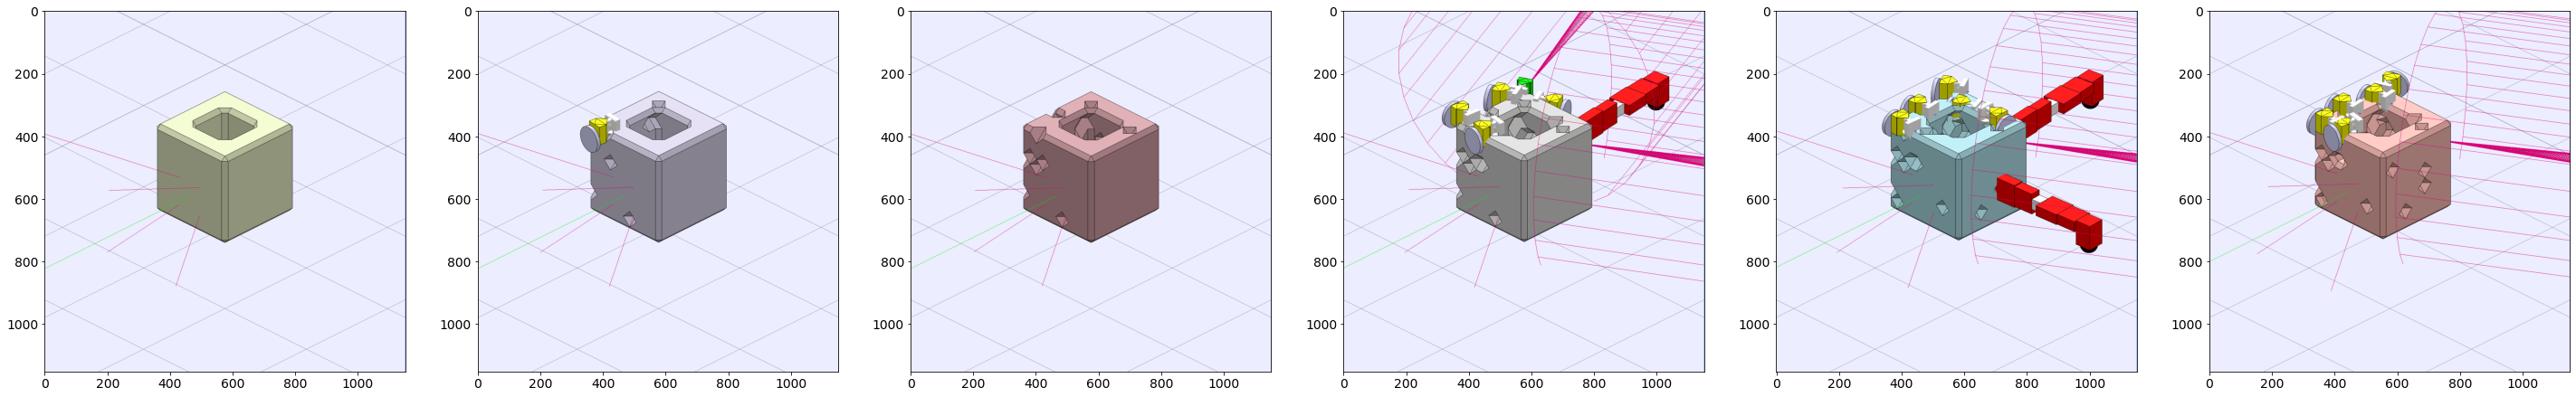

In [27]:
# Get images
linead_id = id_robot[50]
images = []
for l in lineages[linead_id]:
    image_name = "robot_" + str(l) + "_3.png"
    img = Image.open(folders[folderID] + "/images/" + image_name)
    images.append(img)
print(lineages[linead_id])
    
columns = len(images)
height = len(images) * 50
fig = plt.figure(facecolor='white')
# plt.figure(figsize=(50, height))
# plt.figure(figsize=(50, height))
plt.gcf().set_size_inches(50, height)
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)
plt.savefig(REPOSITORY+ var1 +'robots.png',dpi=200, bbox_inches='tight')

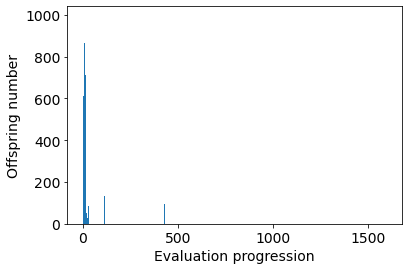

In [71]:
FILE_STATS='stats.csv'
RATIO=0.00029802322 # 5000/8^3
from scipy.stats import mannwhitneyu
with open(REPOSITORY + '/' + FILE_STATS, 'w', newline='') as write_obj:
    csv_writer = csv.writer(write_obj)
    csv_writer.writerow(["Experiments","Stat","p"])
    stat,p = mannwhitneyu(expCoverage[0],expCoverage[1])
    csv_writer.writerow([EXPERIMENTS[0]+'+'+EXPERIMENTS[1], stat,p])
    stat,p = mannwhitneyu(expCoverage[1],expCoverage[2])
    csv_writer.writerow([EXPERIMENTS[1]+'+'+EXPERIMENTS[2], stat,p])
    csv_writer.writerow(["Experiment","Q1","Q2","Q3"])
    for i in range(len(EXPERIMENTS)):
        quantile1 = np.quantile(expCoverage[i], .25)
        quantile2 = np.quantile(expCoverage[i], .50)
        quantile3 = np.quantile(expCoverage[i], .75)
        csv_writer.writerow([EXPERIMENTS[i],quantile1/RATIO,quantile2/RATIO,quantile3/RATIO])

IndexError: list index out of range

In [ ]:
markers = ['o','>','o','>','o','>','o']
colours = [[230/255,25/255,75/255],[245/255,130/255,48/255],[255/255,255/255,25/255],[210/255,245/255,60/255],[60/255,180/255,75/255],[70/255,240/255,240/255],[0/255,130/255,200/255],[145/255,30/255,180/255],[240/255,50/255,230/255],[128/255,128/255,128/255],[0,0,0]]
colorIndex = [0,8,9,10]
# colorIndex = [0,6,10]
labels = []
for i in EXPERIMENTS:
    temp = str(int(i)/100)
    labels.append(temp)
    print(temp)
#fig = plt.figure(facecolor='white')
print(len(expDescriptors[0][0]))
fig, (ax1, ax2) = plt.subplots(1, 2)
fig = plt.gcf()
fig.set_size_inches(10, 4)
fig.set_facecolor('white')
exp_wheels = []
exp_sensors= []
for exp in range(len(EXPERIMENTS)):
    wheels = []
    sensors = []
    for i in range(REPLICATES):
        temp_gen_wheels = []
        temp_gen_sensors = []
        for j in range(0,EVALUATIONS,POPULATION):
            temp_gen_wheels.append(np.mean(expDescriptors[exp][i][j-POPULATION:j,5]))
            temp_gen_sensors.append(np.mean(expDescriptors[exp][i][j-POPULATION:j,6]))
        wheels.append(temp_gen_wheels)
        sensors.append(temp_gen_sensors)
    df_wheels = pd.DataFrame(wheels).melt()
    df_sensors = pd.DataFrame(sensors).melt()
    sns.lineplot(x="variable", y="value", data = df_wheels, ax=ax1, marker=markers[exp], color = colours[colorIndex[exp]])
    sns.lineplot(x="variable", y="value", data = df_sensors, ax=ax2, marker=markers[exp], color = colours[colorIndex[exp]])
    exp_wheels.append(wheels)
    exp_sensors.append(sensors)

for ax in fig.get_axes():
    ax.label_outer()

TICKPOS =  np.arange(0,4/16,1/16)
TICKLABEL = range(0,4,1)
ax1.set_yticks(TICKPOS)
ax2.set_yticks(TICKPOS)
ax1.set_yticklabels(TICKLABEL)
TICKLABEL = range(0,14,1)
TICKPOS = range(1,15,1)
ax1.set_xticks(TICKPOS)
ax1.set_xticklabels(TICKLABEL)
ax2.set_xticks(TICKPOS)
ax2.set_xticklabels(TICKLABEL)
ax1.set(xlabel="Generations", ylabel="Organs number")
ax2.set(xlabel="Generations")
# ax2.legend(EXPERIMENTS)
ax2.legend(labels)
ax1.set_title('Wheels')
ax2.set_title('Sensors')

plt.savefig(REPOSITORY+'/Prog.png',dpi=200, bbox_inches='tight')

In [ ]:
from scipy.stats import mannwhitneyu
# print(bud_max_fitness[bud][0])

 
tempDat0 = np.array([[float(y) for y in x] for x in exp_wheels[0]])
tempDat1 = np.array([[float(y) for y in x] for x in exp_wheels[1]])
tempDat2 = np.array([[float(y) for y in x] for x in exp_wheels[2]])
tempDat3 = np.array([[float(y) for y in x] for x in exp_wheels[3]])

temp_list0 = []
temp_list1 = []
temp_list2 = []
for i in range(len(tempDat1[0])):
#     print(i)
    out0 = [x[i] for x in tempDat0]
    out1 = [x[i] for x in tempDat1]
    out2 = [x[i] for x in tempDat2]
    out3 = [x[i] for x in tempDat3]
#     print(len(out1))
    # print(tempDat[:][0])

    stat,p = mannwhitneyu(out0,out1)
#     print("---",p)
    #temp_list0.append(round(p, 3))
    temp_list0.append(p<0.05)
    stat,p = mannwhitneyu(out1,out2)
#     print("---",p)
    #temp_list1.append(round(p, 3))
    temp_list1.append(p<0.05)
    stat,p = mannwhitneyu(out2,out3)
#     print("---",p)
    #temp_list1.append(round(p, 3))
    temp_list2.append(p<0.05)
#     plt.plot(temp_list)
#     plt.ylim([0,1])
print(temp_list0)
print(temp_list1)
print(temp_list2)

In [ ]:
from scipy.stats import mannwhitneyu
# print(bud_max_fitness[bud][0])

 
tempDat0 = np.array([[float(y) for y in x] for x in exp_sensors[0]])
tempDat1 = np.array([[float(y) for y in x] for x in exp_sensors[1]])
tempDat2 = np.array([[float(y) for y in x] for x in exp_sensors[2]])
tempDat2 = np.array([[float(y) for y in x] for x in exp_sensors[3]])

temp_list0 = []
temp_list1 = []
temp_list2 = []
for i in range(len(tempDat1[0])):
#     print(i)
    out0 = [x[i] for x in tempDat0]
    out1 = [x[i] for x in tempDat1]
    out2 = [x[i] for x in tempDat2]
    out3 = [x[i] for x in tempDat3]
#     print(len(out1))
    # print(tempDat[:][0])

    stat,p = mannwhitneyu(out0,out1)
#     print("---",p)
    #temp_list0.append(round(p, 3))
    temp_list0.append(p<0.05)
    stat,p = mannwhitneyu(out1,out2)
#     print("---",p)
    #temp_list1.append(round(p, 3))
    temp_list1.append(p<0.05)
    stat,p = mannwhitneyu(out2,out3)
#     print("---",p)
    #temp_list1.append(round(p, 3))
    temp_list2.append(p<0.05)
#     plt.plot(temp_list)
#     plt.ylim([0,1])
print(temp_list0)
print(temp_list1)
print(temp_list2)